In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import seaborn as sns
import json
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import gc
from tqdm.notebook import tqdm as tqdm

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']
print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append('../detector/')
from DeepFakeDetector import DeepFakeDetector
sys.path.append('../util/')
from detectorDebugUtils import *

/home/joni/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,NaN,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ...",NaN,ptpwappdyx.mp4,2020-02-17
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,0.0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17


In [6]:
# Get all test videos
filenames = []
for filename in Path(video_path).rglob('*.mp4'):
    filenames.append(filename)
print(len(filenames))

119146


In [7]:
deepfake_models_directory = None
third_party_models_directory = '../pretrained_models'

deepFakeDetector = DeepFakeDetector(deepfake_models_directory=deepfake_models_directory,
                                    third_party_models_directory=third_party_models_directory,
                                    n_first_frames=10,
                                    n_spaced_frames=7)

cuda:0
Loaded video frame sampler.
Loaded face detectors.
Loaded pytorch facenet face embeddings model.
Loaded 0 small face classifier and 0 large face classifier models.
Loaded 0 face sequence classifier models.
Loaded 0 second level xgb classifier models, 0 logistic regression models and 0 LightGBM models
##################################################
DeepFakeDetector v.0.8.2
Sample 10 first frames and 7 spaced frames.
Number of max retries is 4
On error cases, predict 0.5
##################################################


In [8]:
featNames = deepFakeDetector.GetFeatureNames()
print("Num features: " + str(len(featNames)))
featNames

Num features: 4


array(['small_face_embedding_max_centroid_diff', 'small_face_embedding_max_consecutive_diff',
       'small_face_embedding_max_spaced_consecutive_diff', 'small_face_embedding_std_centroid_diff'], dtype='<U48')

In [9]:
%%time
feats = deepFakeDetector.GetFeatures(filenames[0])
feats

CPU times: user 4.76 s, sys: 194 ms, total: 4.95 s
Wall time: 1.56 s


[array([0.617461, 0.340462, 0.977045, 0.112286], dtype=float32)]

In [10]:
%%time
index = 3000
# 11 = two persons
datasOfTrackedPersons = deepFakeDetector.GetFeatures(filenames[index],return_data=True)
print(filenames[index])

/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_00/dfdc_train_part_0/sxyrkshzsg.mp4
CPU times: user 7.04 s, sys: 94.2 ms, total: 7.13 s
Wall time: 2 s


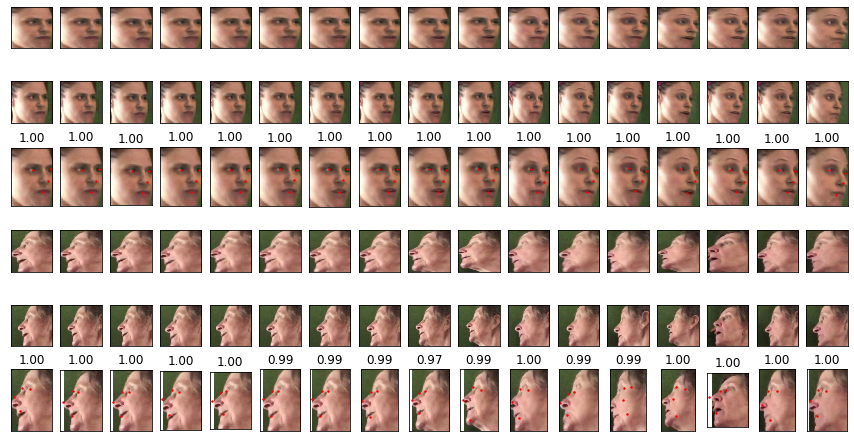

In [11]:
plotFaceSamples(datasOfTrackedPersons, n_frames=17)

### Detect face from one real and crop the same areas from all corresponding fakes 

In [12]:
df_originals = df[df['original'].isnull()]

In [19]:
original_sample = df_originals.iloc[23]['index']
fake_samples = df[df['original'] == original_sample]['index'].values

In [20]:
def getFilepath(fn):
    for f in filenames:
        if fn in str(f):
            return str(f)
    return None

In [21]:
realpath = getFilepath(original_sample)
realpath

'/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_30/qiuzeqtfjh.mp4'

In [22]:
fakepaths = [getFilepath(sample) for sample in fake_samples]
fakepaths = [x for x in fakepaths if x is not None]
fakepaths

['/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_30/szmlrbcfnd.mp4',
 '/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_30/abfcpgmncf.mp4',
 '/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_30/gmhbgvobqy.mp4',
 '/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_30/cshpzaoovu.mp4',
 '/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_30/itzmizklti.mp4',
 '/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_30/kokkoxtvph.mp4',
 '/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_30/oizgrthylf.mp4',
 '/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_30/hymahjaygt.mp4',
 '/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_30/bltfgsdelz.mp4']

In [24]:
%%time
datasOfTrackedPersons = deepFakeDetector.GetFeatures(realpath,return_data=True,replicate_videoPaths=fakepaths)

CPU times: user 42.8 s, sys: 598 ms, total: 43.4 s
Wall time: 8.23 s


Display original and all fake replicates

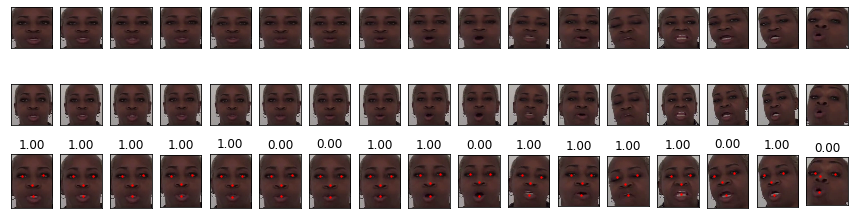

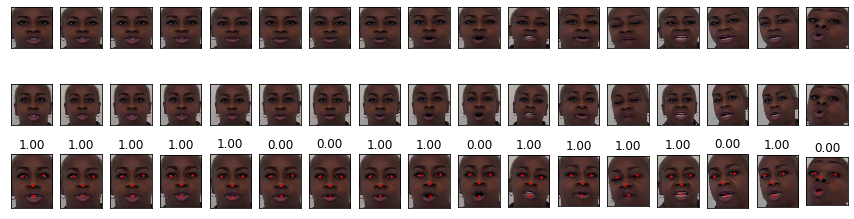

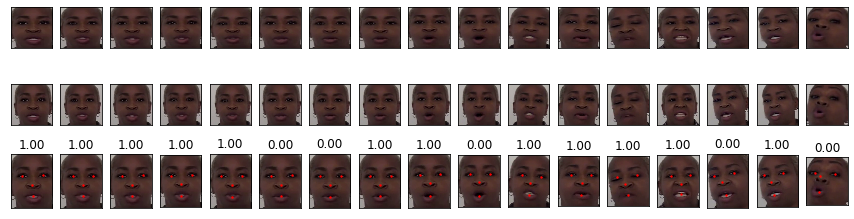

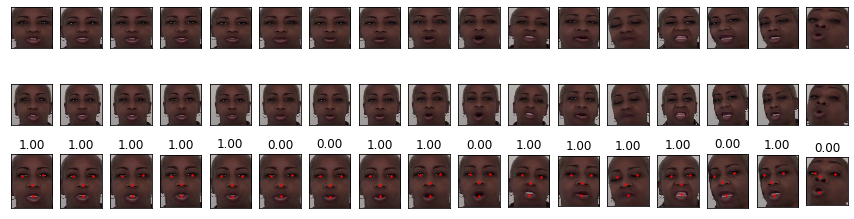

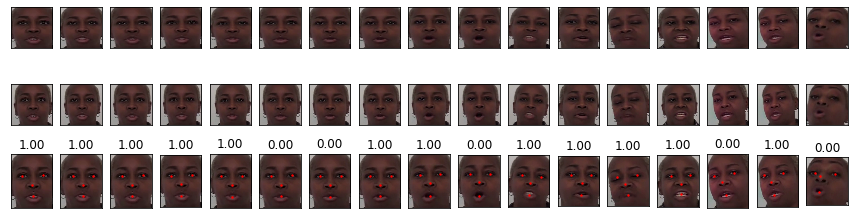

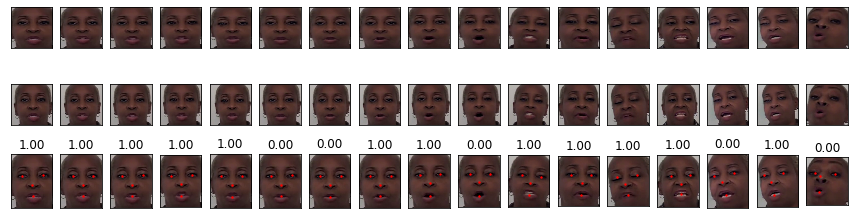

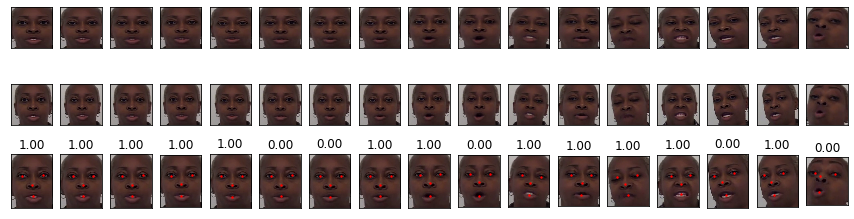

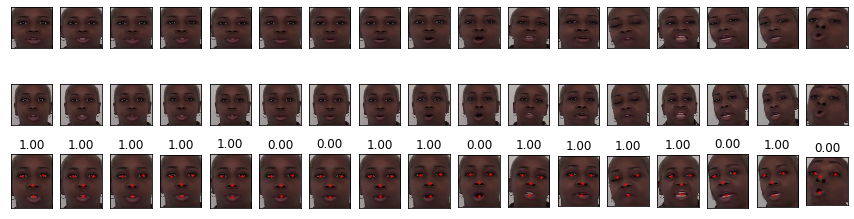

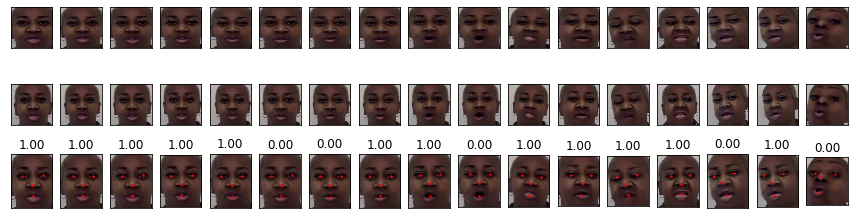

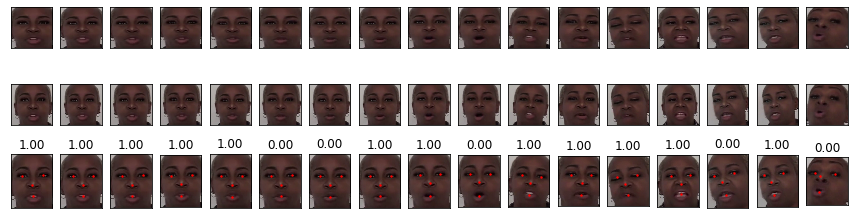

In [26]:
for replicateData in datasOfTrackedPersons:
    plotFaceSamples([replicateData], n_frames=17)

   ### Save files

In [65]:
DIR_SAVE_SMALL_FACES = '../../DeepFake/small_faces_2'
DIR_SAVE_LARGE_FACES = '../../DeepFake/large_faces_2'
DIR_SAVE_RAW_FACES = '../../DeepFake/raw_faces_2'
DIR_SAVE_EMBEDDINGS = '../../DeepFake/face_embeddings_2'

if not os.path.isdir(DIR_SAVE_SMALL_FACES):
    os.mkdir(DIR_SAVE_SMALL_FACES)
if not os.path.isdir(DIR_SAVE_LARGE_FACES):
    os.mkdir(DIR_SAVE_LARGE_FACES)
if not os.path.isdir(DIR_SAVE_RAW_FACES):
    os.mkdir(DIR_SAVE_RAW_FACES)
if not os.path.isdir(DIR_SAVE_EMBEDDINGS):
    os.mkdir(DIR_SAVE_EMBEDDINGS)

In [66]:
def getNamePart(filename):
        fileparts = str(filename).split('/')
        return fileparts[len(fileparts)-1].replace('.mp4','')

def saveStuff(embeddings, small_faces, large_faces, raw_faces, name_id, n_frames):
    # save embeddings
    emb = np.array(embeddings[:n_frames])
    np.save(os.path.join(DIR_SAVE_EMBEDDINGS, name_id + '_0.npy'), emb)
    if(len(embeddings)>n_frames):
        emb = np.array(embeddings[n_frames:])
        np.save(os.path.join(DIR_SAVE_EMBEDDINGS, name_id + '_1.npy'), emb)
    # save small faces
    for j, face_img in enumerate(small_faces):
        im = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(os.path.join(DIR_SAVE_SMALL_FACES, name_id + '_' + str(j//n_frames) + '_' + str(j%n_frames) + '.png'), im)
    # save large faces
    for j, face_img in enumerate(large_faces):
        im = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(os.path.join(DIR_SAVE_LARGE_FACES, name_id + '_' + str(j//n_frames) + '_' + str(j%n_frames) + '.png'), im)
    # save raw faces
    for j, face_img in enumerate(raw_faces):
        im = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(os.path.join(DIR_SAVE_RAW_FACES, name_id + '_' + str(j//n_frames) + '_' + str(j%n_frames) + '.png'), im)
            
def processSample(videoname, ind, n_frames=17, skip_if_exist=True, delete_existing_second_person_files=False):
    realpath = getFilepath(videoname)
    fake_samples = df[df['original'] == videoname]['index'].values
    fakepaths = [getFilepath(sample) for sample in fake_samples]
    fakepaths = [x for x in fakepaths if x is not None]
    
    realName = getNamePart(realpath)
    
    def removeIfExist(file):
        if os.path.isfile(file):
            os.remove(file)
    
    
    if delete_existing_second_person_files:
        for name_id in ([realName]+[getNamePart(path) for path in fakepaths]):
            check_and_remove = [os.path.join(DIR_SAVE_EMBEDDINGS, name_id + '_1.npy')]
            for i in range(n_frames):
                check_and_remove.append(os.path.join(DIR_SAVE_SMALL_FACES, name_id + '_1_' + str(i) + '.png'))
                check_and_remove.append(os.path.join(DIR_SAVE_LARGE_FACES, name_id + '_1_' + str(i) + '.png'))
                check_and_remove.append(os.path.join(DIR_SAVE_RAW_FACES, name_id + '_1_' + str(i) + '.png'))
            for file in check_and_remove:
                removeIfExist(file)     
    elif skip_if_exist and os.path.isfile(os.path.join(DIR_SAVE_EMBEDDINGS, realName + '_' + str(0) + '.npy')):
        # skip if already made
        return
    
    embeddings, small_faces, large_faces, raw_faces = [],[],[],[]
    embeddings_repl, small_faces_repl, large_faces_repl, raw_faces_repl = [],[],[],[] 
    try:
        (embeddings,small_faces,
         large_faces,raw_faces,
         embeddings_repl,small_faces_repl,
         large_faces_repl,raw_faces_repl) = deepFakeDetector.GetFeatures(realpath,
                                                                         return_data=True,
                                                                         replicate_videoPaths=fakepaths)
    except:
        print("Exception in " + videoname + "  index: " + str(ind))
        return videoname
    try:
        # Save real embeddings and images
        saveStuff(embeddings, small_faces, large_faces,raw_faces, realName, n_frames)
        
        # Save fake replicates
        for (rep_embeddings, 
             rep_small_faces, 
             rep_large_faces, 
             rep_raw_faces,
             filename) in zip(embeddings_repl,
                              small_faces_repl, 
                              large_faces_repl, 
                              raw_faces_repl,
                              fakepaths):
            saveStuff(rep_embeddings, rep_small_faces, rep_large_faces, rep_raw_faces, getNamePart(filename), n_frames=n_frames)
    except:
        print("Save exception in " + videoname + " index: " + str((ind)))
        return videoname
    return None

In [23]:
%%time
processSample(original_sample,0)

CPU times: user 192 ms, sys: 0 ns, total: 192 ms
Wall time: 191 ms


In [ ]:
failedFiles = []
for i, file in tqdm(enumerate(df_originals['index'].values), total=len(df_originals)):
    if (i%1000==0):
        print(i)
    failed = processSample(file, i)
    if failed is not None:
        failedFiles.append(failed)
        
with open('failed_sampling.txt', 'w') as f:
    for item in failedFiles:
        f.write("%s\n" % item)

In [ ]:
len(failedFiles)